In [1]:
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'white'
import pandas as pd
import matplotlib.pyplot as plt

## 一. Data inspection: 检查distribution

In [2]:
datapath = 'generated_data/similar_sentences.xlsx'
df = pd.read_excel(datapath)
df.head()

,label,sentence1,sentence2,similarity,category3,doc1,doc2
0,STYLYSTIC,dispute between the contracting parties concer...,disputes between contracting parties regarding...,0.967505,['State-to-state Arbitration'],t1996-66-chile-greece-bit-1996,t2000-13-bangladesh-switzerland-bit-2000
1,IRRELEVANT,said period shall start on the day on which th...,royalties and other payments deriving from rig...,0.841040,[],t1996-66-chile-greece-bit-1996,t2000-13-bangladesh-switzerland-bit-2000
2,STYLYSTIC,between the contracting parties concerning the...,any dispute between the contracting parties c...,0.965822,['State-to-state Arbitration'],t1994-147-kazakhstan-ukraine-bit-1994,t2009-107-slovakia-syrian-arab-republic-bit-2009
3,STYLYSTIC,provisions of paragraph 1 of this article shal...,where a contracting party expropriates the as...,0.965317,['Expropriation Conditions'],t1994-147-kazakhstan-ukraine-bit-1994,t2009-107-slovakia-syrian-arab-republic-bit-2009
4,STYLYSTIC,respect of investment made prior to the date o...,with regard to investments made before the not...,0.971554,['Termination'],t2004-38-china-finland-bit-2004,t2004-43-congo-democratic-republic-of-the-jord...


<AxesSubplot:xlabel='label'>

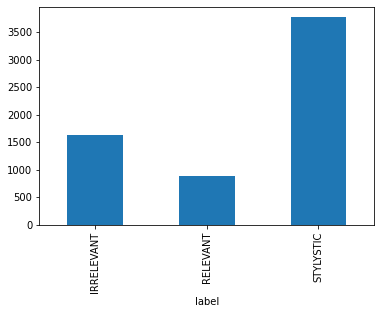

In [3]:
df.groupby(['label']).size().plot.bar()

## 二. bert tokenizer demo

In [4]:
from transformers import BertTokenizer
from transformers import RobertaTokenizer
#tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
example_text = 'I will watch Memento tonight'
bert_input = tokenizer(example_text, example_text ,padding='max_length', max_length = 20, 
                       truncation=True, return_tensors="pt")

In [5]:
bert_input

{'input_ids': tensor([[  101,  1045,  2097,  3422,  2033, 23065,  3892,   102,  1045,  2097,
          3422,  2033, 23065,  3892,   102,     0,     0,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]])}

In [6]:
print(bert_input['input_ids'])
print(bert_input['attention_mask'])

tensor([[  101,  1045,  2097,  3422,  2033, 23065,  3892,   102,  1045,  2097,
          3422,  2033, 23065,  3892,   102,     0,     0,     0,     0,     0]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]])


In [7]:
example_text = tokenizer.decode(bert_input.input_ids[0])
example_text

'[CLS] i will watch memento tonight [SEP] i will watch memento tonight [SEP] [PAD] [PAD] [PAD] [PAD] [PAD]'

## 三. Data set: 数据集

In [8]:
import torch
import numpy as np
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
labels = {'RELEVANT': 0, 'STYLYSTIC': 1, 'IRRELEVANT': 2}

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['label']]
        self.texts = [tokenizer(s1, s2, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for s1, s2 in zip(df['sentence1'], df['sentence2'])]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

train set splt:

In [9]:
np.random.seed(42)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42), 
                                     [int(.8*len(df)), int(.9*len(df))])

print(len(df_train),len(df_val), len(df_test))

5032 629 629


## 四. Model: 模型

In [10]:
from torch import nn
from transformers import BertModel

class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 3)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):
        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

As you can see from the code above, BERT model outputs two variables:
1. The first variable, which we named _ in the code above, contains the embedding vectors of all of the tokens in a sequence.
2. The second variable, which we named pooled_output, contains the embedding vector of [CLS] token. For a text classification task, it is enough to use this embedding as an input for our classifier.

We then pass the pooled_output variable into a linear layer with ReLU activation function. At the end of the linear layer, we have a vector of size 5, each corresponds to a category of our labels (sport, business, politics, entertainment, and tech).

## 五. Training: 训练

In [11]:
from torch.optim import Adam
from tqdm import tqdm

def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=16, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=16)

    use_cuda = torch.cuda.is_available()
    #use_cuda = False
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')
                  
EPOCHS = 20
model = BertClassifier()
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 315/315 [01:49<00:00,  2.88it/s]


Epochs: 1 | Train Loss:  0.051                 | Train Accuracy:  0.653                 | Val Loss:  0.041                 | Val Accuracy:  0.754


100%|██████████| 315/315 [01:49<00:00,  2.88it/s]


Epochs: 2 | Train Loss:  0.031                 | Train Accuracy:  0.830                 | Val Loss:  0.029                 | Val Accuracy:  0.841


100%|██████████| 315/315 [01:49<00:00,  2.87it/s]


Epochs: 3 | Train Loss:  0.023                 | Train Accuracy:  0.900                 | Val Loss:  0.023                 | Val Accuracy:  0.873


100%|██████████| 315/315 [01:49<00:00,  2.87it/s]


Epochs: 4 | Train Loss:  0.016                 | Train Accuracy:  0.931                 | Val Loss:  0.017                 | Val Accuracy:  0.921


100%|██████████| 315/315 [01:49<00:00,  2.87it/s]


Epochs: 5 | Train Loss:  0.012                 | Train Accuracy:  0.960                 | Val Loss:  0.013                 | Val Accuracy:  0.948


100%|██████████| 315/315 [01:49<00:00,  2.88it/s]


Epochs: 6 | Train Loss:  0.009                 | Train Accuracy:  0.972                 | Val Loss:  0.010                 | Val Accuracy:  0.951


100%|██████████| 315/315 [01:49<00:00,  2.88it/s]


Epochs: 7 | Train Loss:  0.007                 | Train Accuracy:  0.982                 | Val Loss:  0.009                 | Val Accuracy:  0.962


100%|██████████| 315/315 [01:49<00:00,  2.88it/s]


Epochs: 8 | Train Loss:  0.005                 | Train Accuracy:  0.989                 | Val Loss:  0.008                 | Val Accuracy:  0.965


100%|██████████| 315/315 [01:49<00:00,  2.87it/s]


Epochs: 9 | Train Loss:  0.004                 | Train Accuracy:  0.993                 | Val Loss:  0.007                 | Val Accuracy:  0.971


100%|██████████| 315/315 [01:49<00:00,  2.87it/s]


## 六. Evaluation: 测试

In [11]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=16)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:
        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    
evaluate(model, df_test)

Test Accuracy:  0.991
